# Load modules and data

In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
from sklearn import svm
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import LeaveOneOut
from sklearn.utils import shuffle
from skfeature.function.similarity_based import fisher_score

In [2]:
# Set the current directory
os.chdir(os.getcwd())

In [3]:
# Load the data and shuffle
df = pd.read_excel('svm_data.xlsx', index_col = 0)
df = shuffle(df, random_state = 0)

df.head()

,class,rsn01,rsn02,rsn03,rsn04,rsn05,rsn06,rsn07,rsn08,rsn09,...,ftpn_l_supramarginal_gyrus_post,ftpn_r_ang_gy,ftpn_r_inferior_frontal_gyrus,ftpn_r_insular,ftpn_r_loc_sup,ftpn_r_mfg,ftpn_r_mtg_post,ftpn_r_mtg_temp_occ,ftpn_r_supramarginal_gyrus_ant,ftpn_r_supramarginal_gyrus_post
A03,1,20.747116,8.410531,17.308617,14.172358,9.782778,11.645107,3.799927,5.508025,7.645144,...,2.660061,4.761257,3.677583,0.430702,3.154317,4.903845,2.288471,3.014223,2.627086,3.857278
A02,1,15.252696,6.760952,9.789093,10.099967,13.358784,4.852035,5.938119,7.125640,7.250939,...,2.417054,5.104171,6.296066,0.053538,4.304273,6.247542,1.540595,2.680884,2.453317,3.923074
A15,1,10.807675,3.537536,4.938450,11.953330,4.386522,3.363261,3.588006,3.218596,3.512035,...,1.351379,2.244964,0.986020,-0.760034,1.817569,1.558930,-0.357083,0.710059,2.583791,1.557682
A06,1,17.201234,8.340808,16.107629,15.988339,13.477469,12.153988,8.754315,3.890907,4.710657,...,1.708126,3.825347,0.333224,-1.951272,3.154877,1.890318,-0.031129,2.070916,1.314286,2.244453
A13,1,11.708175,6.263255,9.306400,14.498034,9.527482,9.386930,5.902103,4.903636,8.946936,...,3.200618,6.811551,4.064736,-0.472963,4.097515,5.868757,4.122707,4.820505,4.072557,4.401588


In [4]:
# Extract labels (y vector) and features (X vector)
y = df['class']
X = df.iloc[:, 1:].values.tolist()

# Evaluate SVM performance using leave-one-out CV

In [5]:
# Load SVM and leave one out cross validation
clf = svm.SVC(kernel = 'rbf', C = 1, probability = True)
loo = LeaveOneOut()

In [6]:
# Create a results dictionary
pred_dict = {}
actual_dict = {}
idx_dict = {}

# Initiate a for-loop to leave one subject out as test data
for train_index, test_index in loo.split(X):
    X_test = pd.DataFrame(X).iloc[test_index, :].values.tolist()
    X_train = pd.DataFrame(X).iloc[train_index, :].values.tolist()
    y_test = y.iloc[test_index].values.tolist()
    y_train = y.iloc[train_index].values.tolist()
    
    # Calculate fisher scores on training data and rank features
    score = fisher_score.fisher_score(X_train, y_train)
    idx = fisher_score.feature_ranking(score)
    
    # Create y_pred and y_actual lists to store results
    y_pred = {}
    y_actual = {}
    
    # Create a for-loop to evaluate SVM performance with 1 to j number of features
    for j in range(1, len(df.columns)):
        num_fea = j
        
        # Extract the selected features for the training and test data
        selected_features_train = pd.DataFrame(X_train).iloc[:, idx[0:num_fea]].values.tolist()
        selected_features_test = pd.DataFrame(X_test).iloc[:, idx[0:num_fea]].values.tolist()
        
        # Fit SVM and make predictions on test data
        clf.fit(selected_features_train, y_train)
        test_score = clf.predict_proba(selected_features_test)[:, 0]
        
        y_pred[j] = float(test_score)
        y_actual[j] = y_test

    # Create lists of results from dictionary values and append to respective dictionary
    pred = list(y_pred.values())
    act = list(y_actual.values())

    pred_dict[int(test_index)] = pred
    actual_dict[int(test_index)] = act
    idx_dict[int(test_index)] = idx

In [22]:
# Convert each dictionary to a dataframe
pred_df = pd.DataFrame(pred_dict)
actual_df = pd.DataFrame(actual_dict)

# The columns contain the value of each cross-validation split (I.e. probability for that subject)
# and rows contain the number of features used

# Rename the columns and index to reflect this more clearly
pred_df.columns = df.index
pred_df.index = list(range(1, 61))
pred_df = pred_df.transpose()

# Save DF
#pred_df.to_excel('confidence_values.xlsx')

pred_df.head()

,1,2,3,4,5,6,7,8,9,10,...,51,52,53,54,55,56,57,58,59,60
A03,0.385754,0.449367,0.446868,0.336829,0.342525,0.418762,0.407769,0.388412,0.564917,0.533049,...,0.405278,0.390250,0.435937,0.519431,0.443082,0.544523,0.475966,0.376589,0.365003,0.421723
A02,0.646966,0.606243,0.627950,0.643631,0.577059,0.556903,0.553596,0.532180,0.477842,0.523373,...,0.412045,0.427065,0.391361,0.445530,0.386361,0.433937,0.436677,0.521843,0.449979,0.558739
A15,0.329947,0.339028,0.353408,0.350248,0.445863,0.425361,0.285668,0.351883,0.284236,0.381317,...,0.520174,0.442572,0.376146,0.459483,0.467198,0.329337,0.334718,0.525727,0.611146,0.361397
A06,0.548833,0.782771,0.710452,0.755904,0.719612,0.663273,0.751697,0.598950,0.939045,0.768157,...,0.531630,0.270766,0.665215,0.494671,0.488629,0.511344,0.466550,0.452756,0.508745,0.339044
A13,0.314910,0.208947,0.241555,0.184313,0.172378,0.263380,0.270136,0.513082,0.396542,0.474480,...,0.493344,0.454197,0.437356,0.430651,0.439283,0.436849,0.432766,0.444049,0.444445,0.432371


In [8]:
# Create results dictionary
auc_dict = {}
auc_dict['Number of features'] = ['AUC Score']

# Create a loop that takes all 24 cross-validations for each number of features
for i in range(len(pred_df.columns)):
    pred = pred_df.iloc[:, i].values.tolist()
    actual = actual_df.iloc[i, :].values.tolist()
    
    # Calculate the AUC
    auc = float(format(roc_auc_score(actual, pred), '.3f'))
    
    # Append to the results dictionary, setting the key as the current loop + 1 (to give the number of features)
    num_feats = i + 1
    auc_dict[num_feats] = auc

In [9]:
# View results
auc_dict

{'Number of features': ['AUC Score'],
 1: 0.579,
 2: 0.414,
 3: 0.329,
 4: 0.271,
 5: 0.407,
 6: 0.386,
 7: 0.443,
 8: 0.493,
 9: 0.407,
 10: 0.564,
 11: 0.621,
 12: 0.564,
 13: 0.707,
 14: 0.643,
 15: 0.621,
 16: 0.614,
 17: 0.679,
 18: 0.593,
 19: 0.679,
 20: 0.6,
 21: 0.607,
 22: 0.707,
 23: 0.7,
 24: 0.721,
 25: 0.65,
 26: 0.521,
 27: 0.657,
 28: 0.536,
 29: 0.614,
 30: 0.721,
 31: 0.707,
 32: 0.6,
 33: 0.636,
 34: 0.764,
 35: 0.679,
 36: 0.736,
 37: 0.757,
 38: 0.786,
 39: 0.564,
 40: 0.679,
 41: 0.836,
 42: 0.8,
 43: 0.743,
 44: 0.807,
 45: 0.836,
 46: 0.764,
 47: 0.857,
 48: 0.821,
 49: 0.821,
 50: 0.771,
 51: 0.825,
 52: 0.8,
 53: 0.85,
 54: 0.957,
 55: 0.786,
 56: 0.671,
 57: 0.921,
 58: 0.786,
 59: 0.779,
 60: 0.743}

# Graph results

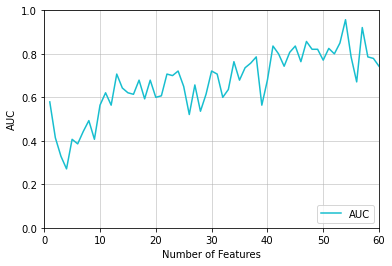

In [23]:
# Get AUC scores and number of features
auc_scores = list(auc_dict.values())[1:]
features = list(auc_dict.keys())[1:]

# Plot values
fig, ax = plt.subplots()
ax.plot(features, auc_scores, label = 'AUC', color = 'tab:cyan')
ax.set_xlim(0 , 60)
ax.set_ylim(0 , 1)
ax.grid(True, linewidth = 0.5)
ax.set_xlabel('Number of Features')
ax.set_ylabel('AUC')
ax.legend(loc = 'lower right')

#plt.savefig('SVM performance.png', dpi = 600)

# Create ROC curve

In [24]:
# Extract data at maximum AUC of 54 features
predictions = pred_df.iloc[:, 47].values.tolist()
actual_classes = y

In [25]:
# Calculate FPR, TPR, thresholds and AUC
fpr, tpr, thresholds = roc_curve(actual_classes, predictions, pos_label = 1)
auc = round(roc_auc_score(actual_classes, predictions), 3)

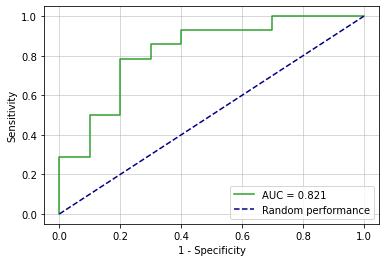

In [27]:
# Plot data
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color = 'tab:green', label = 'AUC = {}'.format(auc))
ax.plot([0, 1], color = 'navy', linestyle = '--', label = 'Random performance')
ax.set_xlabel('1 - Specificity')
ax.set_ylabel('Sensitivity')
ax.grid(True, linewidth = 0.5)
ax.legend(loc = 'lower right')

#plt.savefig('SVM ROC.png', dpi = 600)

In [28]:
# Print out the values of TPR, FPR, and respective thresholds
print('FPR')
for i in fpr:
    print(i)
    
print('TPR')
for i in tpr:
    print(i)

print('Thresholds')
for i in thresholds:
    print(i)

FPR
0.0
0.0
0.0
0.1
0.1
0.2
0.2
0.3
0.3
0.4
0.4
0.7
0.7
1.0
TPR
0.0
0.07142857142857142
0.2857142857142857
0.2857142857142857
0.5
0.5
0.7857142857142857
0.7857142857142857
0.8571428571428571
0.8571428571428571
0.9285714285714286
0.9285714285714286
1.0
1.0
Thresholds
1.5854079932970941
0.5854079932970941
0.513359413778335
0.5
0.46511661149960215
0.4636481517923801
0.4229117341541967
0.3942543087064432
0.389844565986948
0.38804052779820275
0.3847578055503754
0.3588954619664408
0.3284003968009893
0.09107610527904925


# Determine the most important features

In [29]:
# The idx_dict contains an ordered list of the most important features
# over 24 LOOCV splits of the data.

# Convert this dictionary to a dataframe
features = pd.DataFrame(idx_dict)
features.index = list(range(1, 61))
features.index.name = 'feature rank'
features.columns.name = 'cross-validation split'
features.head()

cross-validation split,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
feature rank,,,,,,,,,,,,,,,,,,,,,
1,35,35,35,23,35,35,35,35,35,35,...,35,35,35,35,35,35,23,35,35,35
2,40,40,23,35,23,23,23,23,23,40,...,18,18,40,7,23,40,3,23,23,23
3,7,7,40,7,40,18,40,40,7,7,...,7,40,7,40,40,36,35,40,40,40
4,23,41,7,40,7,1,7,7,40,23,...,36,7,41,41,7,23,40,7,7,7
5,36,23,47,18,41,47,1,47,41,36,...,39,36,39,36,36,7,18,41,39,41


In [30]:
# Save this to excel to determine the most common feature at each rank
#features.to_excel('ranked_features.xlsx')